# Basic analysis methods within the `spatialdata` ecosystem 

In this notebook, we will show how `scanpy` can be used to perform dimensionality reduction and clustering on Xenium data. 

A `SpatialData` object is interoperable with external methods thanks to its modular design that builds upon established data structures. 

For instance, in this notebook the decoupling of the geometries and the gene expression annotations for cells allows us to operate on the `AnnData` table using `scanpy`, store back the results in the `SpatialData` object and plot the processed data using `spatialdata-plot`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spatialdata as sd
import spatialdata_plot as sdp
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq
import pandas as pd

for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")

sdata_xenium = sd.read_zarr("../data/xenium.zarr")
sdata_xenium

spatialdata: 0.2.3.dev2+ga2aab25
spatialdata_plot: 0.2.3.post1.dev68+gc8b0b34
scanpy: 1.10.2
squidpy: 1.6.0


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-workshops/data/xenium.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate sy

## Subset the Xenium data for the scope of this workshop 

Data has 12165021 transcript locations.


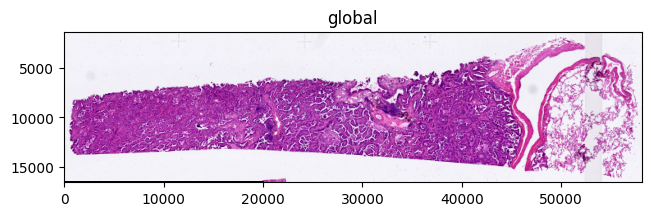

In [3]:
print(f"Data has {sdata_xenium.points['transcripts'].compute().shape[0]} transcript locations.")
sdata_xenium.pl.render_images("he_image").pl.show()

Crop has 2683201 transcript locations.


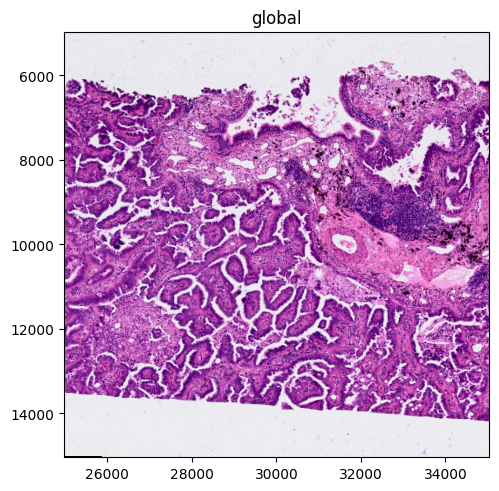

In [4]:
sdata_crop = sdata_xenium.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[25000, 5000],
    max_coordinate=[35000, 15000],
    target_coordinate_system="global",
)
print(
    f"Crop has {sdata_crop.points['transcripts'].compute().shape[0]} transcript locations."
)
sdata_crop.pl.render_images("he_image").pl.show()

In [5]:
sdata_crop.tables["table"]

AnnData object with n_obs × n_vars = 33727 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

Standard `Scanpy` workflow ([find the `Scanpy` tutorials here](https://scanpy.readthedocs.io/en/stable/tutorials/)).

In [6]:
adata = sdata_crop.tables["table"]

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_15306/550196305.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


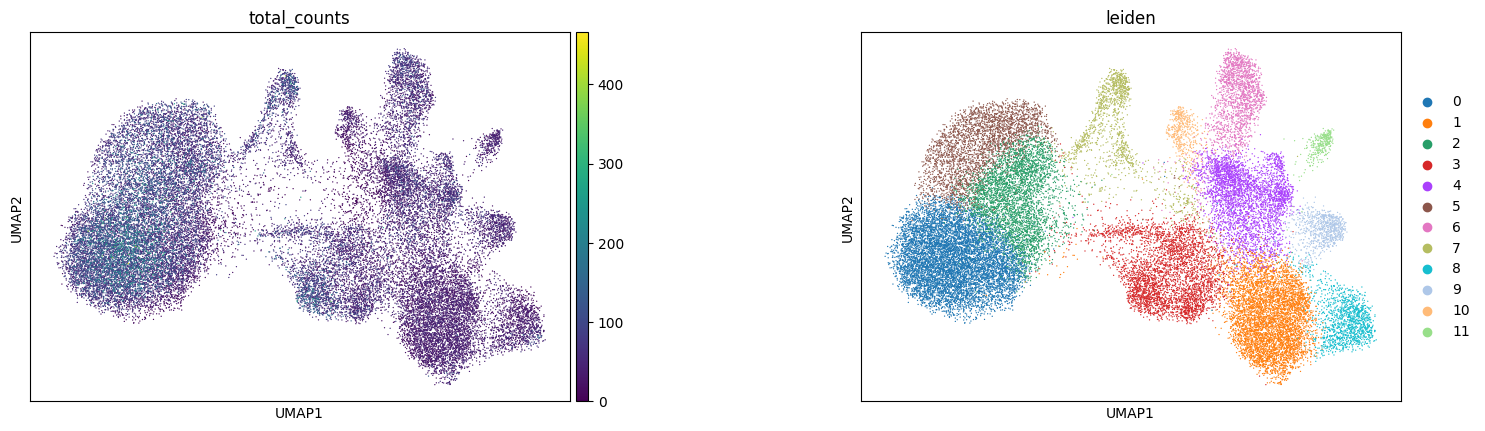

In [7]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

### Rename clusters

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


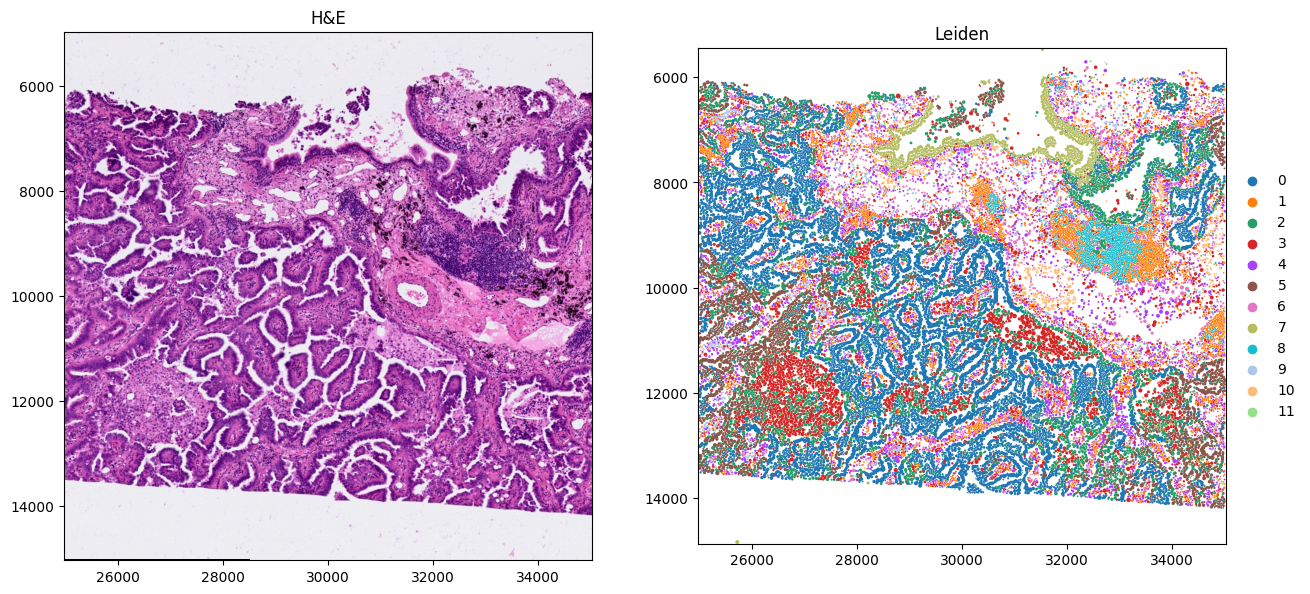

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

sdata_crop.pl.render_images("he_image").pl.show(ax=axs[0], title="H&E")

sdata_crop.pl.render_shapes(
    "cell_circles",
    color="leiden",
    method="matplotlib",
).pl.show(ax=axs[1], title="Leiden")

## Modify the groups based on the Leiden UMAP

In [9]:
for i in [2, 5]:
    sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=True)

for i in [1, 4, 6, 8, 10, 11]:
    sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "9", inplace=True)

/tmp/ipykernel_15306/2302851329.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=True)
/tmp/ipykernel_15306/2302851329.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=Tru

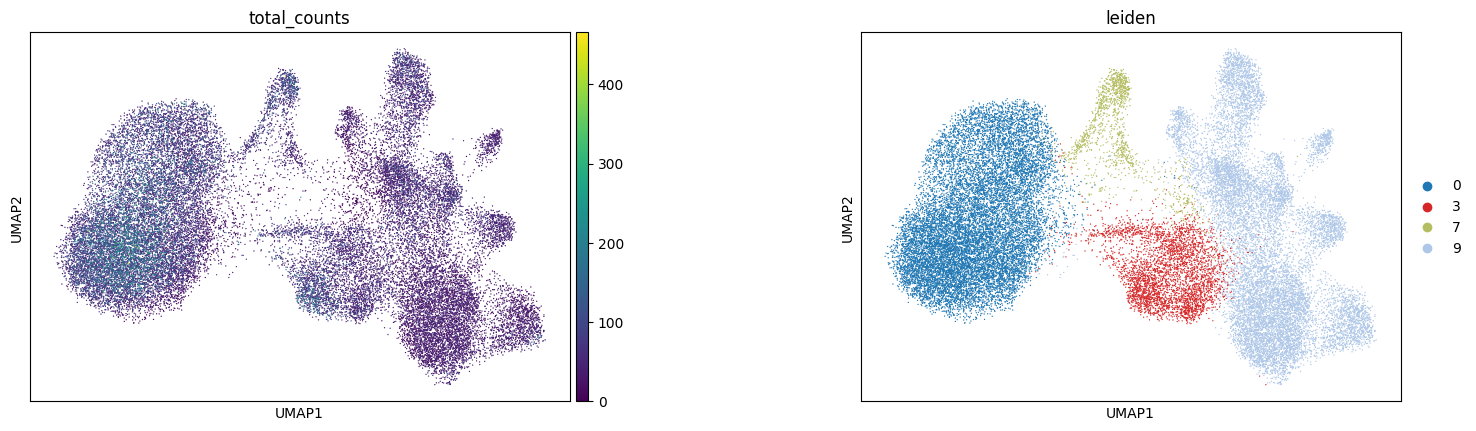

In [10]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


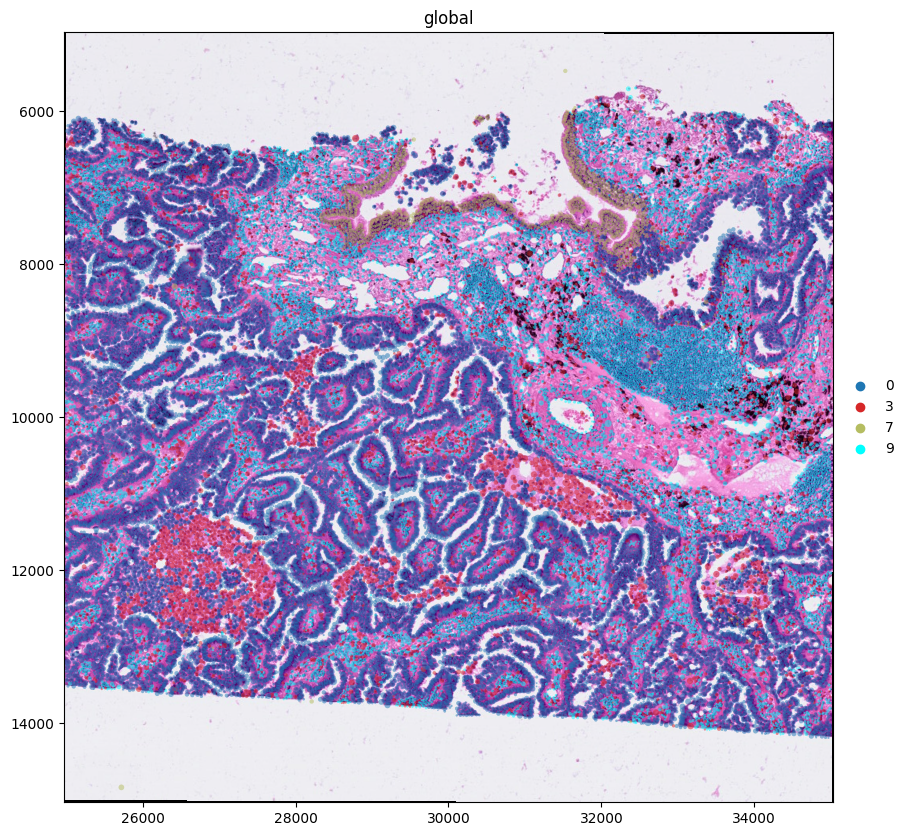

In [11]:
sdata_cropfig, ax = plt.subplots(1, 1, figsize=(10, 10))

sdata_crop.pl.render_images("he_image").pl.render_shapes(
    "cell_circles",
    color="leiden",
    fill_alpha=0.5,
    palette=["#1f77b4", "#d62728", "#b5bd61", "cyan"],
    groups=["0", "3", "7", "9"],
    method="matplotlib",
).pl.show(ax=ax)